# Start Pooling

# Start Pooling

In [1]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import dirichlet

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib



In [2]:
bond_cache = {}

def get_bond_metrics(pool, pay_dam_pool_it, nominal_pool_it):
    pool_key = tuple(sorted(pool))  # Create a unique key for the pool
    if pool_key not in bond_cache:
        # If result isn't cached, compute and store it
        pay_dam_temp = {c: pay_dam_pool_it[c] for c in pool}
        nominal_temp = {c: nominal_pool_it[c] for c in pool}
        bond_metrics, returns, tot_coverage, premium_dic, nominal, es_metrics, MES_cty = bond_fct.mlt_cty_bond(
            countries=pool,
            pay_dam_df_dic=pay_dam_temp,
            nominals_dic=nominal_temp,
            opt_cap=True,
        )
        bond_cache[pool_key] = {
            "ibrd": premium_dic["ibrd"] * nominal,
            "regression": premium_dic["regression"] * nominal,
            "Returns": returns
            }
    return bond_cache[pool_key]

## Define Countries and Variables for Cat Bond Development

In [3]:
bond_metrics_sng_dic = {}
returns_sng_dic = {}
premium_dic_sng_dic = {}
nominal_sng_dic = {}
pay_dam_df_sng_dic = {}
es_metrics_sng_dic = {}
int_grid_sng_dic = {}
imp_per_event_flt_sng_dic = {}
imp_admin_evt_flt_sng_dic = {}

In [28]:
#choose country
countries = [212, 548, 670, 776, 174, 584, 308, 882, 570, 90]
countries_150 = [548, 90]
countries_30 = [212,670,776, 174, 584, 308, 882, 570]
#minimum damage to be protected per grid cell calculated using return period
lower_rp = 100

#number of simulated years
r = 10000

#set risk free rate, either single value or array
rf_rates = 0.00


#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd
#set risk muliplier reported by artems
artemis_multiplier = 4.11

#set sharpe ratio to beat
target_sharpe = 0.5

prot_share = 0.008
lower_share = 0.045
prot_rp = 250
lower_rp = 30

num_portfolios = 10000
alpha = 0.1

## Designe Single Country Bonds
### Define Cat Bond function

### Design Cat Bond for Country 1

In [5]:
for cty in countries:
    if cty in bond_metrics_sng_dic:
        print(f"Bond for {cty} already calculated, skipping.")
        continue
    print(f'Create bond for {cty}')
    if cty in countries_150:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                    prot_rp=prot_rp, 
                                                                                                                                                    to_prot_share=lower_share,
                                                                                                                                                    buffer_distance_km=105,
                                                                                                                                                    res_exp=150,
                                                                                                                                                    grid_size=1000,
                                                                                                                                                    buffer_grid_size=3,
                                                                                                                                                    incl_plots=False)
    if cty in countries_30:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                    prot_rp=prot_rp, 
                                                                                                                                                    to_prot_share=lower_share,
                                                                                                                                                    buffer_distance_km=105,
                                                                                                                                                    res_exp=30,
                                                                                                                                                    grid_size=1000,
                                                                                                                                                    buffer_grid_size=3,
                                                                                                                                                    incl_plots=False)
    bond_metrics_sng_dic[cty] = bond_metrics
    returns_sng_dic[cty] = returns
    premium_dic_sng_dic[cty] = premium_dic
    nominal_sng_dic[cty] = nominal
    pay_dam_df_sng_dic[cty] = pay_dam_df
    es_metrics_sng_dic[cty] = es_metrics
    int_grid_sng_dic[cty] = int_grid
    imp_per_event_flt_sng_dic[cty] = imp_per_event_flt
    imp_admin_evt_flt_sng_dic[cty] = imp_admin_evt_flt


pay_dam_pool_it = {}
nominal_pool_it = {}
for i in range(len(countries)):
    pay_dam_pool_it[countries[i]] = pay_dam_df_sng_dic[countries[i]]
    nominal_pool_it[countries[i]] = nominal_sng_dic[countries[i]]

Create bond for 212
Number of tracks in NA basin: 4904
The principal of the cat bond is: 190385817.244 [USD]
Principal as share of GDP: 0.378
Create bond for 548
Number of tracks in SP basin: 9918
The principal of the cat bond is: 256554773.067 [USD]
Principal as share of GDP: 0.282
Create bond for 670
Number of tracks in NA basin: 5476
The principal of the cat bond is: 307641548.326 [USD]
Principal as share of GDP: 0.354
Create bond for 776
Number of tracks in SP basin: 9892
The principal of the cat bond is: 85861645.648 [USD]
Principal as share of GDP: 0.177
Create bond for 174
Number of tracks in SI basin: 580
The principal of the cat bond is: 156119036.255 [USD]
Principal as share of GDP: 0.127
Create bond for 584
Number of tracks in WP basin: 2071
The principal of the cat bond is: 17750172.834 [USD]
Principal as share of GDP: 0.074
Create bond for 308
Number of tracks in NA basin: 4888
The principal of the cat bond is: 351316422.884 [USD]
Principal as share of GDP: 0.337
Create bo

In [69]:
sng_prem = []
for cty in countries:
    sng_prem.append(premium_dic_sng_dic[cty]['regression'] * nominal_sng_dic[cty])
print(sum(sng_prem))

125034553.0638015


In [71]:
(125034553.0638015-85763355.3978401)/125034553.0638015

0.3140827611542103

## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

### Create Multi-Country bond

In [6]:
import itertools

def reverse_optimize_with_exclusions(countries, pay_dam_pool_it, nominal_pool_it):
    def calculate_premium(groups):
        """Helper function to calculate the total premium for given groups."""
        return sum(
            get_bond_metrics(g, pay_dam_pool_it, nominal_pool_it)["regression"] for g in groups
        )

    def optimize(groups):
        """Reverse optimization for a given set of groups."""
        current_premium = calculate_premium(groups)
        print(f"Initial Premium: {current_premium}")

        while len(max(groups, key=len)) > 1:  # Stop if all groups are single countries
            best_split = None
            largest_group = max(groups, key=len)

            for removal in itertools.combinations(largest_group, 1):  # Remove one country
                remaining_group = [x for x in largest_group if x not in removal]
                new_groups = [remaining_group] + [list(removal)] + [g for g in groups if g != largest_group]

                new_premium = calculate_premium(new_groups)
                print(f"Trying split: {new_groups}, Premium: {new_premium}")

                if new_premium <= current_premium:
                    current_premium = new_premium
                    best_split = new_groups

            if best_split:
                groups = best_split
                print(f"New groups: {groups}, Premium: {current_premium}")
            else:
                print("No further improvement found. Stopping.")
                break

        return groups, current_premium

    # Step 1: Optimize the initial pool
    initial_groups = [countries]
    optimized_groups, initial_premium = optimize(initial_groups)

    # Step 2: Attempt to pool the excluded countries
    excluded_countries = [g for g in optimized_groups if len(g) == 1]  # Single-country groups
    if len(excluded_countries) > 1:  # Only proceed if there are at least two excluded countries
        excluded_countries = [c[0] for c in excluded_countries]  # Flatten list of single-country groups
        print(f"Attempting to pool excluded countries: {excluded_countries}")
        new_group = excluded_countries
        new_groups = [g for g in optimized_groups if len(g) > 1] + [new_group]

        new_premium = calculate_premium(new_groups)
        print(f"Premium with excluded countries pooled: {new_premium}")

        if new_premium <= initial_premium:  # If pooling reduces premium, re-optimize
            print("Pooling excluded countries reduced the premium. Re-optimizing.")
            return optimize(new_groups)

    return optimized_groups, initial_premium


In [7]:
test = reverse_optimize_with_exclusions(countries, pay_dam_pool_it, nominal_pool_it)

Initial Premium: 85763355.3978401
Trying split: [[548, 670, 776, 174, 584, 308, 882, 570, 90], [212]], Premium: 93929077.34991328
Trying split: [[212, 670, 776, 174, 584, 308, 882, 570, 90], [548]], Premium: 93388630.38889098
Trying split: [[212, 548, 776, 174, 584, 308, 882, 570, 90], [670]], Premium: 90047882.7836508
Trying split: [[212, 548, 670, 174, 584, 308, 882, 570, 90], [776]], Premium: 89445994.86571588
Trying split: [[212, 548, 670, 776, 584, 308, 882, 570, 90], [174]], Premium: 92459361.74924971
Trying split: [[212, 548, 670, 776, 174, 308, 882, 570, 90], [584]], Premium: 86524667.23325191
Trying split: [[212, 548, 670, 776, 174, 584, 882, 570, 90], [308]], Premium: 92697821.4263308
Trying split: [[212, 548, 670, 776, 174, 584, 308, 570, 90], [882]], Premium: 93163609.18362062
Trying split: [[212, 548, 670, 776, 174, 584, 308, 882, 90], [570]], Premium: 85791953.74526073
Trying split: [[212, 548, 670, 776, 174, 584, 308, 882, 570], [90]], Premium: 95243465.47906196
No furth

In [50]:
sng_ann_ret = {}
for cty in countries:
    sng_ann_ret[cty] = returns_sng_dic[cty]['Annual'][0] 

pool_best = get_bond_metrics(countries, pay_dam_pool_it, nominal_pool_it)["Returns"]
pool_best_ann_ret = pool_best['Annual'][0]

pool_alt_lst = [212, 548, 670, 776, 174, 584, 308, 882, 90]
pool_alt = get_bond_metrics(pool_alt_lst, pay_dam_pool_it, nominal_pool_it)["Returns"]
pool_alt_ann_ret = pool_best['Annual'][0]

In [51]:
df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})

r = np.mean(df_returns,axis=0)

# Create a covariance matrix
covar = df_returns.cov()

In [52]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df_returns.columns)
num_portfolios = 10000

In [53]:
from numpy.random import dirichlet

num_portfolios = 50000  # Number of portfolios to simulate
alpha = 0.3

for _ in range(num_portfolios):
    weights = dirichlet([alpha] * num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, r) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = covar.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # yearly standard deviation
    p_vol.append(sd)

In [54]:
data = {'Returns':p_ret, 'Volatility':p_vol, 'Sharpe Ratio':np.array(p_ret)/np.array(p_vol)}

for counter, symbol in enumerate(df_returns.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [55]:
portfolios  = pd.DataFrame(data)
max_sharpe_idx = portfolios['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolios.loc[max_sharpe_idx]
portfolios.head() # Dataframe of the 10000 portfolios created

,Returns,Volatility,Sharpe Ratio,212 Returns weight,548 Returns weight,670 Returns weight,776 Returns weight,174 Returns weight,584 Returns weight,308 Returns weight,882 Returns weight,570 Returns weight,90 Returns weight
0,0.045902,0.055270,0.830499,0.000005,0.194251,6.386098e-09,0.018065,0.670667,0.007746,0.090179,0.007641,0.011387,0.000059
1,0.048223,0.058330,0.826723,0.139642,0.420929,3.743939e-03,0.060078,0.012262,0.023217,0.002206,0.098293,0.151227,0.088402
2,0.046862,0.043688,1.072665,0.087515,0.000522,1.594448e-02,0.000004,0.273740,0.036013,0.081770,0.040056,0.275139,0.189296
3,0.047736,0.044669,1.068660,0.033352,0.061409,2.265989e-01,0.224557,0.216698,0.004161,0.092263,0.017109,0.050319,0.073533
4,0.046209,0.043203,1.069588,0.094356,0.064927,2.276590e-07,0.058073,0.004609,0.527667,0.069059,0.000978,0.053409,0.126921


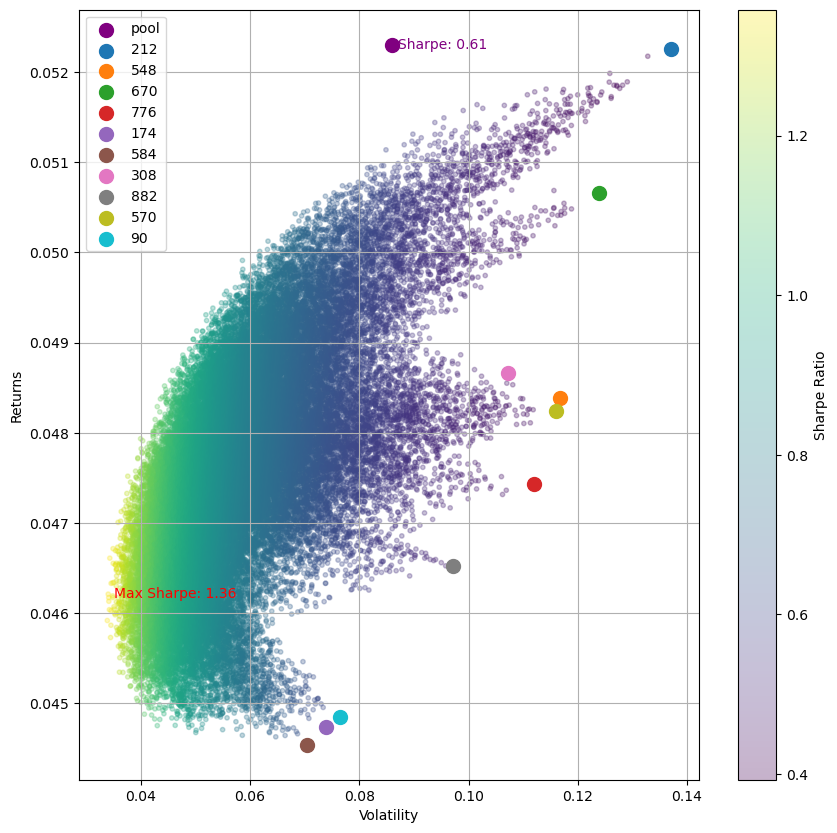

In [56]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', cmap='viridis', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
plt.text(max_sharpe_portfolio['Volatility'] + 0.001,max_sharpe_portfolio['Returns'],f"Max Sharpe: {max_sharpe_portfolio['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')

# Plot pool point
plt.scatter(np.std(pool_best_ann_ret), np.mean(pool_best_ann_ret), label='pool', color='purple', s=100)

# Add label for pool Sharpe ratio
plt.text(np.std(pool_best_ann_ret)+0.001,np.mean(pool_best_ann_ret),f'Sharpe: {np.mean(pool_best_ann_ret)/np.std(pool_best_ann_ret):.2f}',fontsize=10,ha='left',va='center',color='purple')

for cty in countries:
    plt.scatter(np.std(sng_ann_ret[cty]), np.mean(sng_ann_ret[cty]), label=cty, s=100)
plt.legend()

In [57]:
manual_entries = {
    "570 Returns": sng_ann_ret[570],  # Example returns for Country1
    "Pool Alt": pool_alt_ann_ret,  # Example returns for Country2
}

df_returns_alt = pd.DataFrame(manual_entries)

r_alt = np.mean(df_returns_alt,axis=0)

# Create a covariance matrix
covar_alt = df_returns_alt.cov()

In [58]:
p_ret_alt = [] # Define an empty array for portfolio returns
p_vol_alt = [] # Define an empty array for portfolio volatility
p_weights_alt = [] # Define an empty array for asset weights

num_assets = len(df_returns_alt.columns)

In [59]:
num_portfolios = 10000  # Number of portfolios to simulate
alpha = 0.5

for _ in range(num_portfolios):
    weights_alt = dirichlet([alpha] * num_assets)
    weights_alt = weights_alt/np.sum(weights_alt)
    p_weights_alt.append(weights_alt)
    returns_alt = np.dot(weights_alt, r_alt) 
    p_ret_alt.append(returns_alt)
    var_alt = covar_alt.mul(weights_alt, axis=0).mul(weights_alt, axis=1).sum().sum()# Portfolio Variance
    sd_alt = np.sqrt(var_alt) # yearly standard deviation
    p_vol_alt.append(sd_alt)

In [60]:
data_alt = {'Returns':p_ret_alt, 'Volatility':p_vol_alt, 'Sharpe Ratio':np.array(p_ret_alt)/np.array(p_vol_alt)}

for counter, symbol in enumerate(df_returns_alt.columns.tolist()):
    #print(counter, symbol)
    data_alt[symbol+' weight'] = [w[counter] for w in p_weights_alt]

In [61]:
portfolios_alt  = pd.DataFrame(data_alt)
max_sharpe_idx_alt = portfolios_alt['Sharpe Ratio'].idxmax()
max_sharpe_portfolio_alt = portfolios_alt.loc[max_sharpe_idx_alt]
portfolios_alt.head() # Dataframe of the 10000 portfolios created

,Returns,Volatility,Sharpe Ratio,570 Returns weight,Pool Alt weight
0,0.052161,0.083240,0.626639,0.035339,0.964661
1,0.050782,0.070380,0.721544,0.374429,0.625571
2,0.051506,0.073564,0.700147,0.196566,0.803434
3,0.052032,0.080913,0.643059,0.067112,0.932888
4,0.049289,0.089686,0.549569,0.741814,0.258186


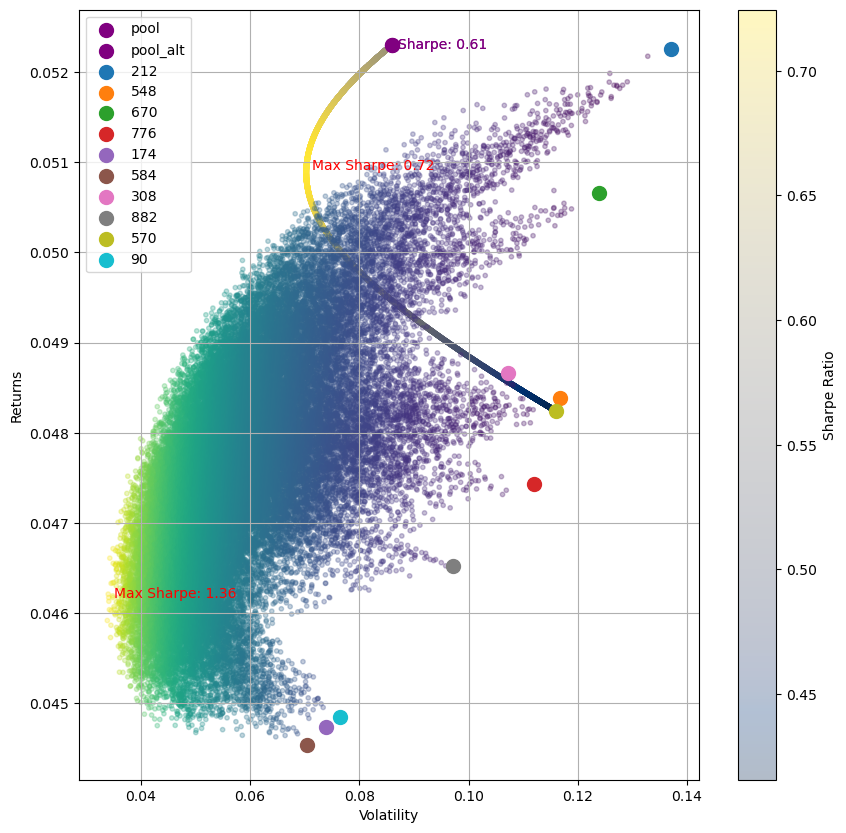

In [68]:
# Plot efficient frontier
portfolios_alt.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', cmap='cividis', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])
plt.text(max_sharpe_portfolio_alt['Volatility'] + 0.001,max_sharpe_portfolio_alt['Returns'],f"Max Sharpe: {max_sharpe_portfolio_alt['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')
# Plot efficient frontier
plt.scatter(x=portfolios['Volatility'], y=portfolios['Returns'], c=portfolios['Sharpe Ratio'], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.text(max_sharpe_portfolio['Volatility'] + 0.001,max_sharpe_portfolio['Returns'],f"Max Sharpe: {max_sharpe_portfolio['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')

# Plot pool point
plt.scatter(np.std(pool_best_ann_ret), np.mean(pool_best_ann_ret), label='pool', color='purple', s=100)

# Add label for pool Sharpe ratio
plt.text(np.std(pool_best_ann_ret)+0.001,np.mean(pool_best_ann_ret),f'Sharpe: {np.mean(pool_best_ann_ret)/np.std(pool_best_ann_ret):.2f}',fontsize=10,ha='left',va='center',color='purple')

# Plot pool point
plt.scatter(np.std(pool_alt_ann_ret), np.mean(pool_alt_ann_ret), label='pool_alt', color='purple', s=100)

# Add label for pool Sharpe ratio
plt.text(np.std(pool_alt_ann_ret)+0.001,np.mean(pool_alt_ann_ret),f'Sharpe: {np.mean(pool_best_ann_ret)/np.std(pool_best_ann_ret):.2f}',fontsize=10,ha='left',va='center',color='purple')

for cty in countries:
    plt.scatter(np.std(sng_ann_ret[cty]), np.mean(sng_ann_ret[cty]), label=cty, s=100)
plt.legend()